# Mapas de Vulnerabilidad COVID-19
## Lima Metropolitana, Perú

### Objetivo

Desarrollar una plataforma de visualización de datos geograficos que soporte la toma de decisiones de instituciones publicas con el objetivo de mitigar los impactos de la crisis del COVID-19.

Los mapas deben estar basados en datos abiertos y replicables a otras ciudados, de modo que permita identificar rápidamente las zonas con una alta concentración de población vulnerable considerando las siguientes dimensiones: accesibilidad vial, nivel socioeconómico, grupo etario, población flotante, densidad poblacional, fuerza laboral, y acceso a servicios básicos.

### Fuentes de datos

- **OpenStreetMap**
- **Censo Nacional 2007**
- **LandScan 2017**
- **TOP 10mil**
- **Dime**

### Dependencias

In [1]:
import geopandas as gpd 
import matplotlib.pyplot as plt 
import numpy as np
import shapely
import pandas as pd
import requests
from h3 import h3

### Acceso a Alimentos y Servicios

El primer paso será conseguir los limites de la ciudad, para Lima Metropolitana se deben combinar los limites de Lima y Callao.

In [2]:
# Fuente de datos
url = 'https://nominatim.openstreetmap.org/search.php'
parameters = {
    'polygon_geojson': '1',
    'format': 'geojson'
}

In [3]:
# Descarga de datos de Lima
posicion = 2 # La posición en que aparece entre los resultados de Nominatim 
parameters['q'] = "Lima, Peru"

response = requests.get(url, params=parameters)
all_results = response.json()
lima_gdf = gpd.GeoDataFrame.from_features(all_results['features'])
lima_ = lima_gdf.iloc[posicion:posicion+1, :] # Limites de Lima provincia

In [4]:
# Descarga de datos de Lima
parameters['q'] = "Callao, Peru"
posicion = 1 # La posición en que aparece entre los resultados de Nominatim 

response = requests.get(url, params=parameters)
all_results = response.json()
callao_gdf = gpd.GeoDataFrame.from_features(all_results['features'])
callao_ =  callao_gdf.iloc[posicion:posicion+1, :] # Limites de Callao provincia constitucional

In [5]:
# Combinacion de limites de lima y callao
lima_metropolitana = gpd.GeoDataFrame(geometry=[pd.concat((lima_, callao_)).unary_union])

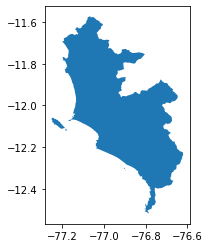

In [6]:
# Visualizamos los datos
lima_metropolitana.plot()
plt.show()

Ahora vamos a utilizar la libreria H3 de Uber para implementar un sistema de grillas que facilite la unificacion de capas de datos geospaciales

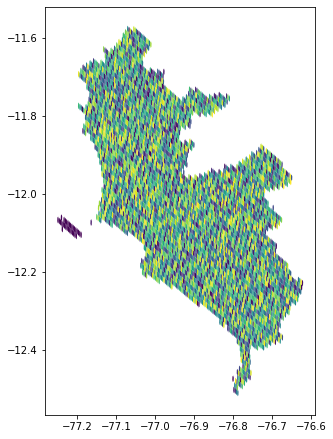

In [116]:
resolution = 9

# Polyfill the city boundaries
h3_centroids = list()
h3_polygons = list()
h3_indexes = list()

lima_polygons = lima_metropolitana.explode().reset_index(drop=True) # Get every polygon in Multipolygon shape

for ix, geo in lima_polygons.iterrows():
    hexagons = h3.polyfill(geo[0].__geo_interface__, res=resolution)
    for hexagon in hexagons:
        h3_centroids.append(shapely.geometry.Point(h3.h3_to_geo(hexagon)))
        h3_polygons.append(shapely.geometry.Polygon(h3.h3_to_geo_boundary(hexagon)))
        h3_indexes.append(hexagon)
        
# Create hexagon dataframe         
lima_metropolitana_h = gpd.GeoDataFrame(h3_indexes, geometry=h3_polygons).drop_duplicates()
lima_metropolitana_centroids = gpd.GeoDataFrame(h3_indexes, geometry=h3_centroids).drop_duplicates()
lima_metropolitana_centroids.crs = 'EPSG:4326'
# Visualize result for sanity check 
lima_metropolitana_h.plot(cmap='viridis', figsize=(5,7.5))

Utilizando datos espaciales abiertos de alta resolucion construiremos algunos mapas para visualizar poblaciones vulnerables 

In [117]:
# Datos de Nivel Socioeconomico y Poblacion por manzana, Fuente: Censo Nacional 2007 INEI
manzanas = gpd.read_file('inputs/manzanas_nse/mz_lima_region.shp')

In [118]:
manzanas.head()

,IDMANZANA,CODZONA,CODMZNA,CLASIFICAC,UBIGEO,NOMBREMZNA,URBANIZACI,NSE07,POB07,VIV07,LONGITUDE,LATITUDE,geometry
0,150728,None,None,1,150728,None,None,None,0,0,-76.671052,-11.916842,"POLYGON ((-76.67379 -11.91608, -76.67329 -11.9..."
1,150728,None,None,1,150728,None,ASOC PUEBLO NUEVO DE BUENOS AIRES,None,0,0,-76.672482,-11.914053,"POLYGON ((-76.67319 -11.91445, -76.67318 -11.9..."
2,150728,None,None,1,150728,None,ASOC PUEBLO NUEVO DE BUENOS AIRES,None,0,0,-76.673467,-11.914446,"POLYGON ((-76.67368 -11.91441, -76.67341 -11.9..."
3,150728,None,None,1,150728,None,ASOC PUEBLO NUEVO DE BUENOS AIRES,None,0,0,-76.673106,-11.914645,"POLYGON ((-76.67351 -11.91473, -76.67321 -11.9..."
4,150728,None,None,1,150728,None,ASOC PUEBLO NUEVO DE BUENOS AIRES,None,0,0,-76.672936,-11.914838,"POLYGON ((-76.67335 -11.91492, -76.67267 -11.9..."


In [119]:
manzanas['NSE07'].unique()

array([None, 'ME', 'MB', 'MA', 'BA', 'AL', '0.'], dtype=object)

In [120]:
# Proporcion de valores perdidos por variable
manzanas.isna().sum() / manzanas.shape[0]

IDMANZANA     0.000000
CODZONA       0.181153
CODMZNA       0.181124
CLASIFICAC    0.000000
UBIGEO        0.000000
NOMBREMZNA    0.557573
URBANIZACI    0.230322
NSE07         0.386055
POB07         0.000000
VIV07         0.000000
LONGITUDE     0.000000
LATITUDE      0.000000
geometry      0.000000
dtype: float64

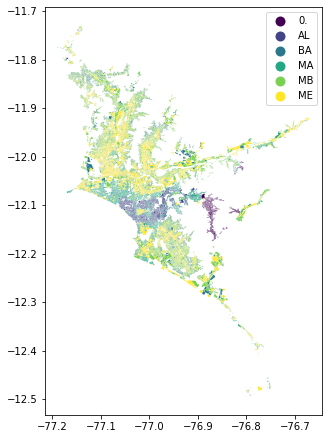

In [121]:
# Distribucion espacial de los niveles socioeconomicos
manzanas.plot(column='NSE07', cmap='viridis', legend=True, figsize=(5, 7.5))

In [122]:
# Intersect Hex Point with CT Polygon
dfh_nse = gpd.tools.sjoin(manzanas, lima_metropolitana_centroids, how="inner")

# Add value to hexagons geodataframe
lima_metropolitana_h.loc[dfh_nse['index_right'],'NSE07'] = dfh_nse['NSE07'].values 

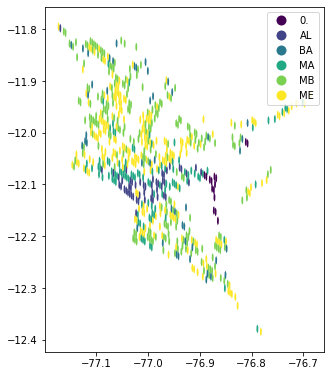

In [123]:
# Visualize results
lima_metropolitana_h.loc[dfh_nse['index_right'],:].plot(column='NSE07', cmap='viridis', legend=True, figsize=(5,7.5))
plt.show()

Ahora vamos a calcular el tiempo caminando de un hexagono hacia un centro de compra de alimento (mercado o bodega)

In [129]:
# Bodegas y Mercados, Fuente: UP
geomarkets = gpd.read_file('inputs/geoMarkets/geoMarkets.shp')
geomarkets.crs = 'EPSG:4326'

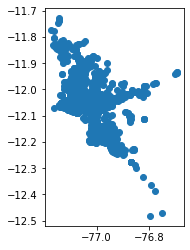

In [137]:
geomarkets.plot()
plt.show()

In [145]:
lima_metropolitana_centroids.distance(geomarkets.loc[0,'geometry']).min()

0.002910563614467072

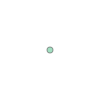

In [141]:
geomarkets.loc[0,'geometry']

In [132]:
distance_matrix = [lima_metropolitana_centroids.distance(geomarkets)]



0       0.508478
1       0.106135
2       0.087840
3       0.079542
4       0.075914
          ...   
5295         NaN
5296         NaN
5297         NaN
5298         NaN
5299         NaN
Length: 5300, dtype: float64

In [133]:
lima_metropolitana_centroids.shape

(5300, 2)

In [135]:
geomarkets.shape

(1293, 11)

In [ ]:
markets_in_h3 = gpd.sjoin(geomarkets, lima_metropolitana, how='inner', op='within')

In [ ]:
markets_in_h3

In [ ]:
markets_count = markets_in_h3[['index_right','ID']].groupby(by='index_right').count()

In [ ]:
markets_count_values = markets_count.values
markets_count_ixs = markets_count.index

In [ ]:
lima_metropolitana.loc[markets_count_ixs,'markets_count'] = markets_count_values

In [ ]:
lima_metrepolitana_h3 = lima_metropolitana.__geo_interface__

In [ ]:
geomarkets

In [ ]:
!export MAPBOX_API_KEY='pk.eyJ1IjoiY2xhdWRpbzk3IiwiYSI6ImNqbzM2NmFtMjB0YnUzd3BvenZzN3QzN3YifQ.heZHwQTY8TWhuO0u2-BxxA'

In [ ]:
import pydeck as pdk

# 2014 locations of car accidents in the UK
UK_ACCIDENTS_DATA = ('https://raw.githubusercontent.com/uber-common/'
                     'deck.gl-data/master/examples/3d-heatmap/heatmap-data.csv')

# Define a layer to display on a map
layer = pdk.Layer(
    'HexagonLayer',
    pd.DataFrame(geomarkets),
    get_position=['longitude', 'latitude'],
    auto_highlight=True,
    elevation_scale=20,
    pickable=True,
    elevation_range=[0, 200],
    extruded=True,                 
    coverage=1)

# Set the viewport location
view_state = pdk.ViewState(
    longitude=-72,
    latitude=-12,
    zoom=6,
    min_zoom=5,
    max_zoom=15,
    pitch=40.5,
    bearing=-27.36)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state)
r.to_html('demo.html')

In [ ]:
fig = go.Figure(
    go.Choroplethmapbox(
        geojson=lima_metropolitana_h3,
        locations=list(range(len(polyfill))), 
        z=lima_metropolitana['markets_count'], 
        marker_opacity=0.5,
        marker_line_width=0
    )
)
fig.update_layout(mapbox_style="carto-positron", mapbox_zoom=10, mapbox_pitch=60, mapbox_bearing=0, mapbox_center = {"lat": -12, "lon": -77})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
f = go.FigureWidget(fig, 'lima')
f.show()

In [ ]:

# Acceso a Agua 
sin_serv_agua = gpd.read_file('inputs/data_pob_servicios_agua_.geojson')

In [ ]:
manzanas_geojson = manzanas.__geo_interface__

In [ ]:
manzanas_geojson = manazanas_geojson

In [ ]:
manzanas_geojson['features'][1]['geometry']

In [ ]:
h3_polyfill = h3.polyfill(manzanas_geojson['features'][1]['geometry'], 15, geo_json_conformant=True)

In [ ]:
h3_polyfill = list(h3_polyfill)

In [ ]:
h3_boundary = h3.h3_to_geo_boundary(h3_polyfill[0])

In [ ]:
from shapely.geometry import Polygon

In [ ]:
h3_boundary

In [ ]:
Polygon(h3_boundary)

In [ ]:
import plotly.

### Puntos de Concentración de Personas

In [ ]:
# Población Flotante por intervalo de tiempo, Datos Telcos


### Empleabilidad

In [ ]:
# Trabajadores por Tipo de Empresa, UP
empresas = pd.read_csv('inputs/empresas_lima.csv')

### Riesgo Desastres Naturales

In [ ]:
# Materiales de Viviendas, Censo 2017 INEI

# Densidad Poblacional, Censo 2017 INEI / FB Humanitarian Data
manzanas
# Riesgo Sísmico, Ministerio de Vivienda PNUD 2010
